<a href="https://colab.research.google.com/github/ValentinaTosic/RI-project/blob/main/resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from pathlib import Path

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
!git clone https://github.com/ValentinaTosic/RI-project.git

Cloning into 'RI-project'...
remote: Enumerating objects: 17085, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17085 (delta 5), reused 3 (delta 0), pack-reused 17068
Receiving objects: 100% (17085/17085), 416.97 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (16763/16763), done.


In [6]:
%cd RI-project/input/100-bird-species/

/content/RI-project/input/100-bird-species


In [7]:
train_path = "./train/"
test_path  = "./test/"
val_path = "./valid/"

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

dataloaders = {
    "train": trainloader,
    "test": testloader
}
datasizes = {
    "train": len(trainset),
    "test": len(testset)
}
CLASSES = list(trainset.class_to_idx.keys())

In [9]:
def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

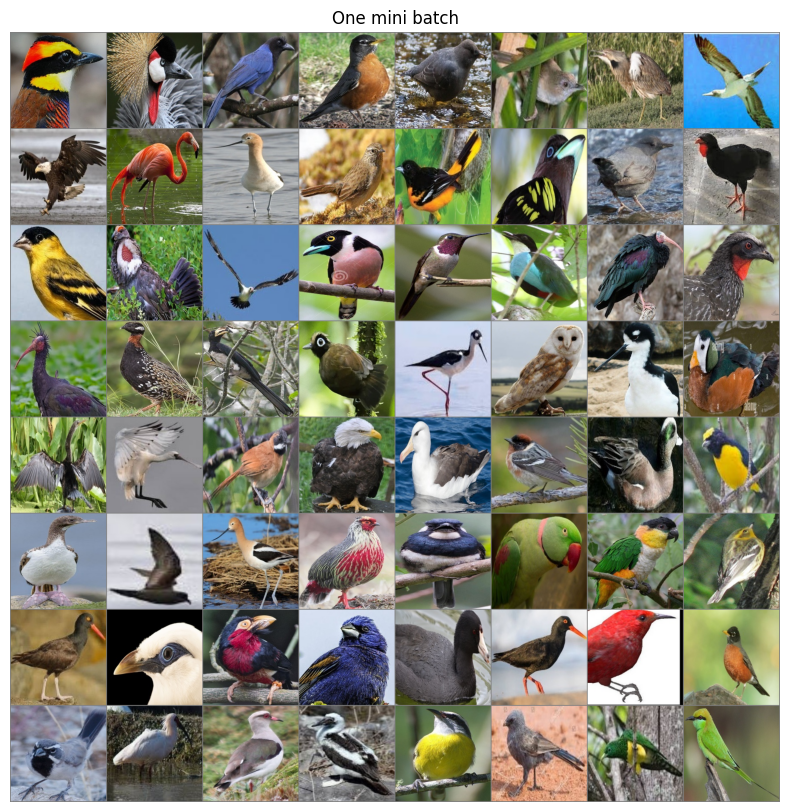

In [10]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [9]:
resnet18 = models.resnet18(pretrained=True)

for param in resnet18.parameters():
    param.requires_grad = False

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(CLASSES))
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.003, momentum=0.9)
exp_lr_sc = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]


In [18]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc, train_loss, total = 0, 0, 0

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs-1))
        print("-"*10)

        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    train_acc += (preds == labels).sum().item()
                    train_loss += loss.item()
                    total += inputs.shape[0]

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                tr_loss = train_loss / len(train_dataloader.dataset)
                train_losses.append(tr_loss)
                train_accs.append(train_acc / total)

            if phase == "train":
                scheduler.step()

            if phase == "test":
              test_losses.append(running_loss / len(test_dataloader.dataset))
              test_accs.append(running_corrects / len(test_dataloader.dataset))

            epoch_loss = running_loss / datasizes[phase]
            epoch_acc = running_corrects.double()/datasizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            if(phase == "test" and epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print("Training complete in {:0f}m {:0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best val Acc: {}:4f".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [22]:
resnet18 = train_model(resnet18, trainloader, testloader,  criterion, optimizer, exp_lr_sc, epochs=5)

Epoch 0/4
----------
train Loss: 0.5057 Acc: 0.9157
test Loss: 0.3666 Acc: 0.9380

Epoch 1/4
----------
train Loss: 0.4536 Acc: 0.9237
test Loss: 0.3384 Acc: 0.9480

Epoch 2/4
----------
train Loss: 0.4154 Acc: 0.9286
test Loss: 0.3172 Acc: 0.9440

Epoch 3/4
----------
train Loss: 0.3844 Acc: 0.9366
test Loss: 0.3056 Acc: 0.9480

Epoch 4/4
----------
train Loss: 0.3802 Acc: 0.9393
test Loss: 0.3020 Acc: 0.9540

Training complete in 106.000000m 17.843869s
Best val Acc: 0.954:4f


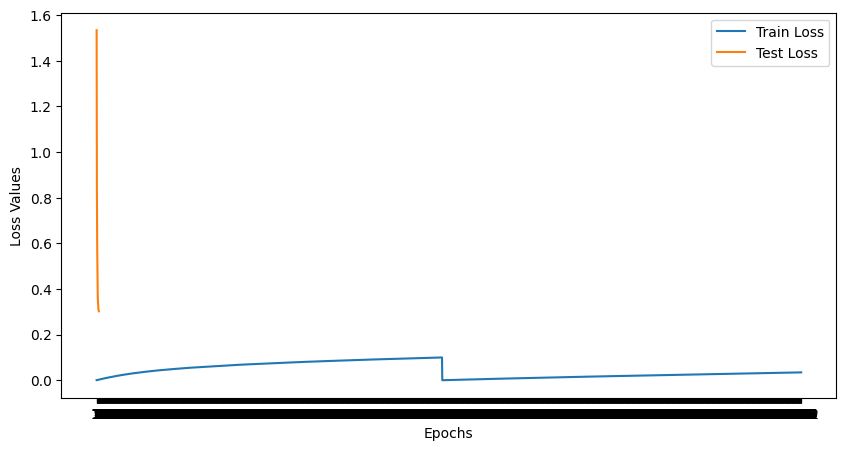

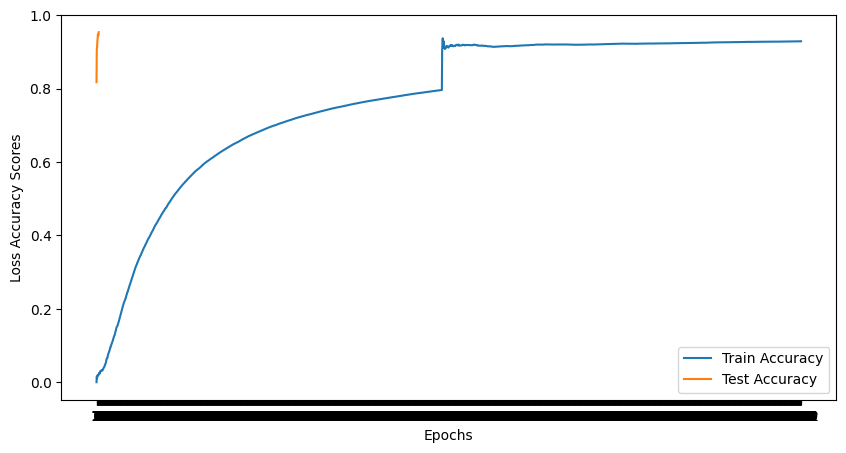

In [23]:
def learning_curves(tr_losses, test_losses, tr_accs, test_accs):

    plt.figure(figsize = (10, 5))
    plt.plot(train_losses, label = "Train Loss")
    plt.plot(test_losses, label = "Test Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss Values")
    plt.xticks(ticks = np.arange(len(tr_losses)), labels = [i for i in range(1, len(tr_losses) + 1)])
    plt.legend(); plt.show()

    plt.figure(figsize = (10, 5))
    plt.plot(train_accs, label = "Train Accuracy")
    plt.plot(test_accs, label = "Test Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Loss Accuracy Scores")
    plt.xticks(ticks = np.arange(len(tr_accs)), labels = [i for i in range(1, len(tr_accs) + 1)])
    plt.legend(); plt.show()

learning_curves(tr_losses=train_losses, test_losses=test_losses, tr_accs=train_accs, test_accs=test_accs)

In [ ]:
def imshowaxis(ax, img, orig, pred):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title(orig + "\n" + pred, color="red")
    else:
        ax.set_title(orig + "\n" + pred)
    ax.axis("off")


def vis_model(model, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figure, ax = plt.subplots(5, 5, figsize=(20, 20))


    with torch.no_grad():
        for i , (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(5):
                for j in range(5):
                    if images_so_far < num_images:
                        imshowaxis(ax[i][j], inputs.cpu().data[images_so_far], CLASSES[labels[images_so_far]], CLASSES[preds[images_so_far]])
                    else:
                        model.train(mode=was_training)
                        return
                    images_so_far += 1
        model.train(mode=was_training)

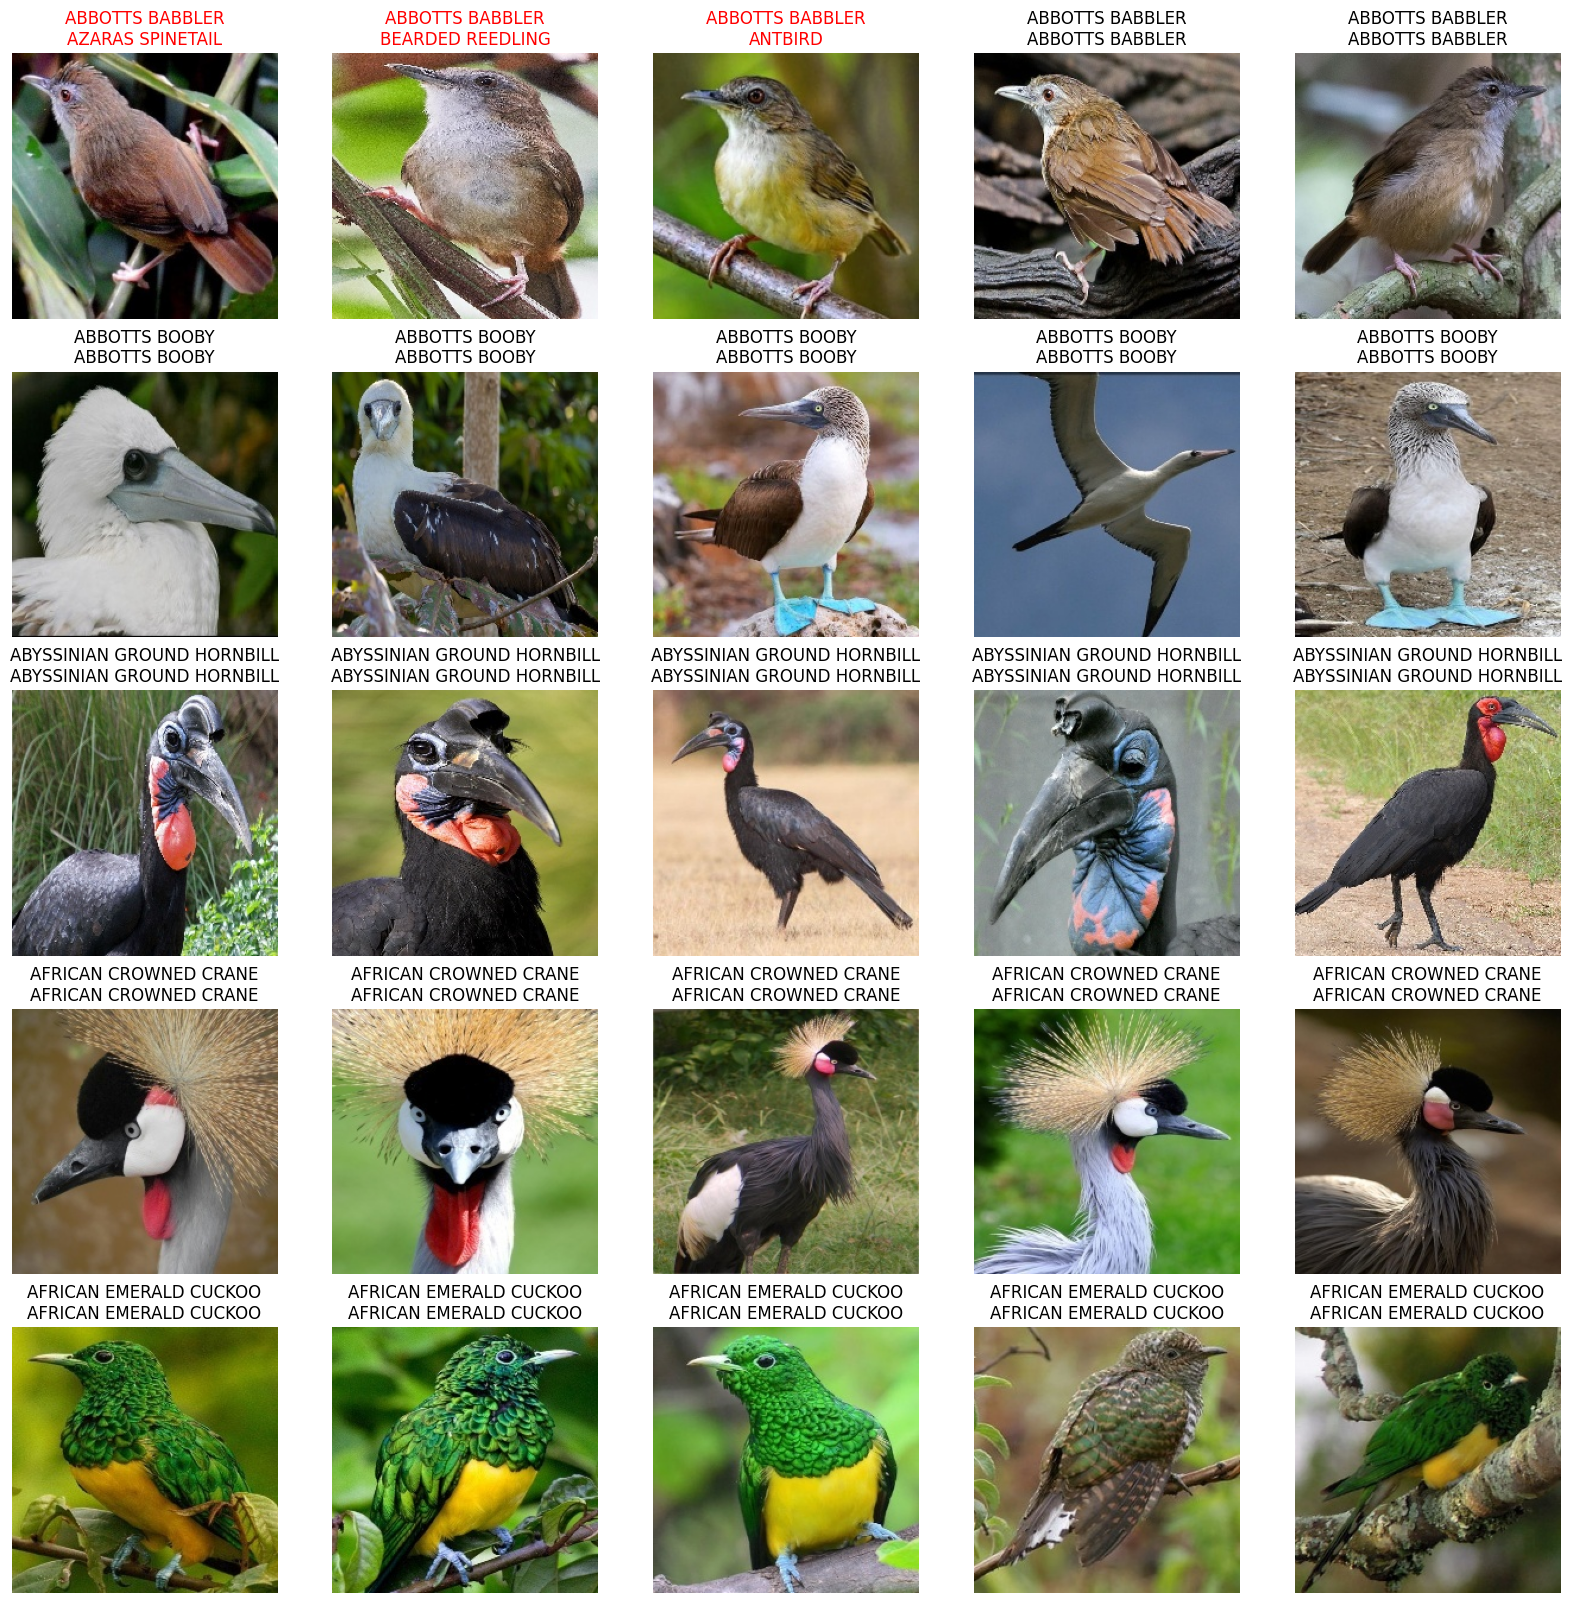

In [25]:
vis_model(resnet18)